# Exercício de Segmentação - exemplo de solução

Neste exercício iremos segmentar o ventrículo esquerdo do coração em imagens relativamente pequenas usando redes neuronais.
Apresenta-se o código de criação de uma rede de segmentação e respectivo treino. A rede não é muito boa, por isso **o exercício é melhorar a qualidade da segmentação, melhorando a rede e/ou o esquema de formação, incluindo a eficiência da carga de dados e o aumento de dados**.

Os dados aqui utilizados são derivados do [Sunnybrook Cardiac Dataset](https://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/) de imagens de RM cardíaca, filtradas para conter apenas segmentações do miocárdio ventricular esquerdo e reduzidas nas dimensões XY.

Primeiro instalamos e importamos MONAI mais outras dependências:

In [2]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
%matplotlib inline

from urllib.request import urlopen
from io import BytesIO

import torch, torch.nn as nn, torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

import monai
from monai.utils import first
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.data import ArrayDataset
from torch.utils.data import DataLoader
from monai.utils import progress_bar
from monai.transforms import (
    Transform,
    Compose,
    EnsureChannelFirst,
    ScaleIntensity,
    ToTensor
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DATA_NPZ = "https://github.com/ericspod/VPHSummerSchool2019/raw/master/scd_lvsegs.npz"
pin_memory=torch.cuda.is_available()

batch_size = 300  #changed from original
num_workers = 10  #changed from original
num_epochs = 600
lr = 5e-4  #changed from original

## 1. Preparação dos dados
Agora carregamos os dados a partir da fonte remota e visualizamos uma amostra:

(420, 64, 64) (420, 64, 64)


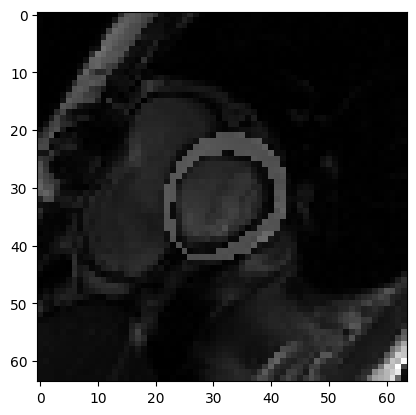

In [4]:
'''
remote_file = urlopen(DATA_NPZ)
npz = BytesIO(remote_file.read())
data = np.load(npz)  # load all the data from the archive
'''
data=np.load('scd_lvsegs.npz')
images = data["images"]  #images in BHW array order
segs = data["segs"]  #segmentations in BHW array order
case_indices = data["caseIndices"]  #the indices in `images` for each case

images = images.astype(np.float32) / images.max()  #normalize images

print(images.shape, segs.shape)
plt.imshow(images[13] + segs[13] * 0.25, cmap="gray")  #show image 13 with segmentation

Dividimos os nossos dados num conjunto de formação e validação, mantendo os últimos 6 casos:

In [5]:
test_index = case_indices[-6, 0]  #keep the last 6 cases for testing

#divide the images, segmentations, and categories into train/test sets
train_images, train_segs = images[:test_index], segs[:test_index]
test_images, test_segs = images[test_index:], segs[test_index:]

Podemos agora criar um objecto de carregamento de dados MONAI para compor lotes durante o treino e outro para validação:

Loading dataset: 100%|██████████| 368/368 [00:00<00:00, 948.18it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([300, 1, 64, 64]) metatensor(0.) metatensor(1.) torch.Size([300, 1, 64, 64])


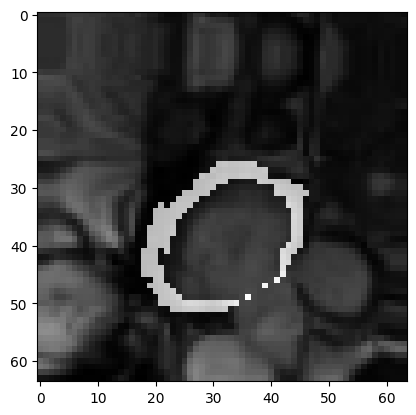

In [6]:
#the solution here does two things: introduce random augmentations and converting the training pipeline to be based on dictionaries.
#This lets us use the CacheDataset type more easily with two part data (image/segmentation).

from monai.data import CacheDataset
from monai.transforms import (
    EnsureChannelFirstd,
    ScaleIntensityd,
    ToTensord,
    RandFlipd,
    RandRotate90d,
    RandZoomd,
    Rand2DElasticd,
    RandAffined,
)

aug_prob = 0.5
keys = ("img", "seg")

#use these when interpolating binary segmentations to ensure values are 0 or 1 only
zoom_mode = monai.utils.enums.InterpolateMode.NEAREST
elast_mode = monai.utils.enums.GridSampleMode.BILINEAR, monai.utils.enums.GridSampleMode.NEAREST

trans = Compose(
    [
        ScaleIntensityd(keys=("img",)),  #rescale image data to range [0,1]
        EnsureChannelFirstd(keys=keys, channel_dim='no_channel'),  #add 1-size channel dimension
        RandRotate90d(keys=keys, prob=aug_prob),
        RandFlipd(keys=keys, prob=aug_prob),
        RandZoomd(keys=keys, prob=aug_prob, mode=zoom_mode),
        Rand2DElasticd(keys=keys, prob=aug_prob, spacing=10, magnitude_range=(-2, 2), mode=elast_mode),
        RandAffined(keys=keys, prob=aug_prob, rotate_range=1, translate_range=16, mode=elast_mode),
        ToTensord(keys=keys),  #convert to tensor
    ]
)

data = [
    {"img": train_images[i], "seg": train_segs[i]} for i in range(len(train_images))
]

ds = CacheDataset(data, trans)
loader = DataLoader(
    dataset=ds,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

#for simplicity we'll keep the existing pipeline for the validation data since it doesn't have any augmentations

val_image_trans = Compose([EnsureChannelFirst(channel_dim='no_channel'),ScaleIntensity(), ToTensor(),])
val_seg_trans = Compose([EnsureChannelFirst(channel_dim='no_channel'), ToTensor()])

val_ds = ArrayDataset(test_images, val_image_trans, test_segs, val_seg_trans)
val_loader = DataLoader(
    dataset=val_ds,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

#%timeit first(loader)

batch = first(loader)
im = batch["img"]
seg = batch["seg"]
print(im.shape, im.min(), im.max(), seg.shape)
plt.imshow(im[0, 0].numpy() + seg[0, 0].numpy(), cmap="gray")

## 2. Definir o modelo
<s>Definimos agora uma rede simples. Isto não faz um bom trabalho, por isso considerem como melhorá-la, adicionando camadas ou outros elementos:</s>

Vamos usar UNet para segmentação da rede.

In [7]:
# class SegNet(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.model = nn.Sequential(
#             # layer 1: convolution, normalization, downsampling
#             nn.Conv2d(1, 2, 3, 1, 1),
#             nn.BatchNorm2d(2),
#             nn.ReLU(),
#             nn.MaxPool2d(3, 2, 1),
#             # layer 2
#             nn.Conv2d(2, 4, 3, 1, 1),
#             # layer 3
#             nn.ConvTranspose2d(4, 2, 3, 2, 1, 1),
#             nn.BatchNorm2d(2),
#             nn.ReLU(),
#             # layer 4: output
#             nn.Conv2d(2, 1, 3, 1, 1),
#         )

#     def forward(self, x):
#         return self.model(x)

O treino é muito simples. Para cada época treinamos em cada lote de imagens do conjunto de treino, treinando assim uma vez com cada imagem, e depois avaliamos com o conjunto de validação.

In [8]:
#net = SegNet()

net = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(8, 16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    #num_res_units=2,
    dropout=0.1,
)

net = net.to(device)

opt = torch.optim.Adam(net.parameters(), lr)
loss = DiceLoss(sigmoid=True)
#metric = DiceMetric(include_background=True, to_onehot_y=False, sigmoid=True, reduction="mean")
metric = DiceMetric(include_background=True, reduction="mean")

step_losses = []
epoch_metrics = []
total_step = 0

for epoch in range(num_epochs):
    net.train()
    #train network with training images
    for batch in loader:
        bimages = batch["img"].to(device)
        bsegs = batch["seg"].to(device)

        opt.zero_grad()

        prediction = net(bimages)
        loss_val = loss(prediction, bsegs)
        loss_val.backward()
        opt.step()

        step_losses.append((total_step, loss_val.item()))
        total_step += 1

    net.eval()
    metric_vals = []

    #test our network using the validation dataset
    with torch.no_grad():
        for bimages, bsegs in val_loader:
            bimages = bimages.to(device)
            bsegs = bsegs.to(device)

            prediction = net(bimages)
            pred_metric = metric(prediction, bsegs)
            metric_vals.append(pred_metric.cpu())

    epoch_metrics.append((total_step, np.average(metric_vals)))

    progress_bar(epoch + 1, num_epochs, f"Validation Metric: {epoch_metrics[-1][1]:.3}")

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


600/600 Validation Metric: 0.0 [==============================]


Agora, fazemos um gráfico dos resultados do treino e constatamos que os resultados não são muito bons:

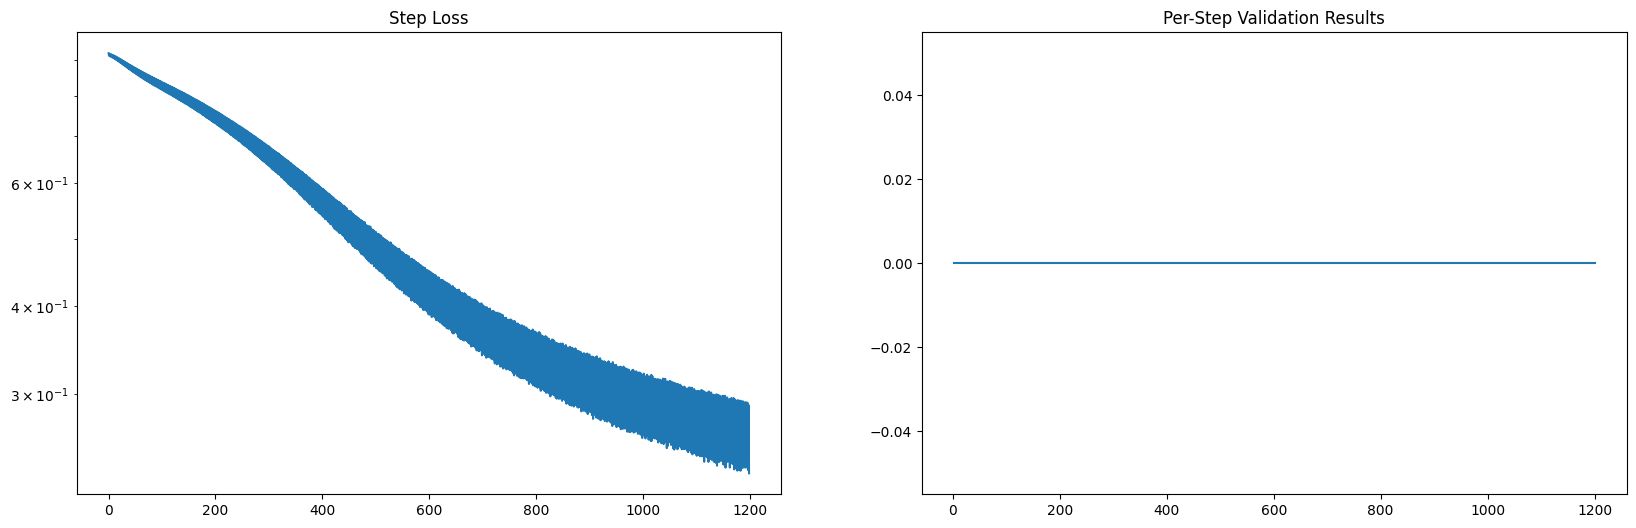

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].semilogy(*zip(*step_losses))
ax[0].set_title("Step Loss")

ax[1].plot(*zip(*epoch_metrics))
ax[1].set_title("Per-Step Validation Results")
plt.show()

<s> As you can see we're not getting good results from our network. The training loss values are jumping around and not decreasing much anymore. The validation score has topped out at 0.25 with is really poor. </s>

<s> It's now up to you to improve the results of our segmentation task. The things to consider changing include the network itself, how data is loaded, how batches might be composed, and what transforms we want to use from MONAI. </s>